In [1]:
# read the hotel reservation file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import numpy as np
import arules
import arules as ar
from arules.utils import five_quantile_based_bins, top_bottom_10, top_5_variant_variables, top_10_variant_variables, specified_list_of_variables, equal_value_range_bins_10

hotel = pd.read_csv('Hotel Reservations.csv')
pd.options.display.max_colwidth = 100

In [2]:
hotel['lead_time'] = hotel['lead_time'].astype('float64')

## Association rules for all attributes (support/confidence experiments)

In [3]:
rules_3, supp_dict = ar.create_association_rules(hotel,max_cols=3,binning_method=five_quantile_based_bins, min_supp=0.01)

True
352
36275



D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\utils\binning.py:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attached_series = binned_series.append(na_series).reindex(series.index)
D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\utils\binning.py:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attached_series = binned_series.append(na_series).reindex(series.index)


Calculating all relevant supports
100%|██████████| 1159/1159 [01:10<00:00, 16.35it/s]

Calculating all feature level rules per variable level rule
100%|██████████| 6156/6156 [00:57<00:00, 106.20it/s]
Overall # of Rules:  82730


In [4]:
rules_2, supp_dict = ar.create_association_rules(hotel,max_cols=2,binning_method=five_quantile_based_bins, min_supp=0.01)

True
352
36275



D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\utils\binning.py:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attached_series = binned_series.append(na_series).reindex(series.index)
D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\utils\binning.py:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attached_series = binned_series.append(na_series).reindex(series.index)


Calculating all relevant supports
100%|██████████| 190/190 [00:02<00:00, 68.76it/s] 

Calculating all feature level rules per variable level rule
100%|██████████| 342/342 [00:01<00:00, 234.63it/s]
Overall # of Rules:  3470


### Select only the rules with confidence > 0.7 and support > 0.05

### For rules with 1 antecedent

In [5]:
rules_2[rules_2['confidence'] > 0.7][rules_2['rule_supp'] > 0.05].sort_values(by='confidence', ascending=False)

C:\Users\cezar\AppData\Local\Temp\ipykernel_9916\2089929830.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rules_2[rules_2['confidence'] > 0.7][rules_2['rule_supp'] > 0.05].sort_values(by='confidence', ascending=False)


,antecedent,consequent,rule print,ant_count,con_count,rule_count,ant_supp,con_supp,rule_supp,confidence,lift,# of all records
438,{'arrival_month': '3'},{'arrival_year': '2018'},arrival_month=3 ==> arrival_year=2018,2358,29761,2358,0.065003,0.820427,0.065003,1.0000,1.2189,36275
439,{'arrival_month': '4'},{'arrival_year': '2018'},arrival_month=4 ==> arrival_year=2018,2736,29761,2736,0.075424,0.820427,0.075424,1.0000,1.2189,36275
1636,{'repeated_guest': '0'},{'no_of_previous_cancellations': '0'},repeated_guest=0 ==> no_of_previous_cancellations=0,35345,35937,35345,0.974363,0.990682,0.974363,1.0000,1.0094,36275
440,{'arrival_month': '5'},{'arrival_year': '2018'},arrival_month=5 ==> arrival_year=2018,2598,29761,2598,0.071620,0.820427,0.071620,1.0000,1.2189,36275
1374,{'repeated_guest': '0'},{'no_of_previous_bookings_not_canceled': '0'},repeated_guest=0 ==> no_of_previous_bookings_not_canceled=0,35345,35463,35345,0.974363,0.977615,0.974363,1.0000,1.0229,36275
...,...,...,...,...,...,...,...,...,...,...,...,...
2946,{'lead_time': '(39.0 - 80.0]'},{'room_type_reserved': 'Room_Type 1'},lead_time=(39.0 - 80.0] ==> room_type_reserved=Room_Type 1,7136,28130,5023,0.196720,0.775465,0.138470,0.7039,0.9077,36275
2472,{'arrival_month': '10'},{'no_of_adults': '2'},arrival_month=10 ==> no_of_adults=2,5317,26108,3732,0.146575,0.719724,0.102881,0.7019,0.9752,36275
1170,{'market_segment_type': 'Offline'},{'booking_status': 'Not_Canceled'},market_segment_type=Offline ==> booking_status=Not_Canceled,10528,24390,7375,0.290227,0.672364,0.203308,0.7005,1.0419,36275
2924,{'arrival_month': '7'},{'type_of_meal_plan': 'Meal Plan 1'},arrival_month=7 ==> type_of_meal_plan=Meal Plan 1,2920,27835,2045,0.080496,0.767333,0.056375,0.7003,0.9127,36275


### For rules with 2 antecedents

In [6]:
rules_3[rules_3['confidence'] > 0.7][rules_3['rule_supp'] > 0.05].sort_values(by='confidence', ascending=False)

C:\Users\cezar\AppData\Local\Temp\ipykernel_9916\2973897398.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rules_3[rules_3['confidence'] > 0.7][rules_3['rule_supp'] > 0.05].sort_values(by='confidence', ascending=False)


,antecedent,consequent,rule print,ant_count,con_count,rule_count,ant_supp,con_supp,rule_supp,confidence,lift,# of all records
44185,"{'lead_time': '(11.0 - 39.0]', 'repeated_guest': '0'}",{'no_of_previous_cancellations': '0'},"lead_time=(11.0 - 39.0], repeated_guest=0 ==> no_of_previous_cancellations=0",7358,35937,7358,0.202839,0.990682,0.202839,1.0000,1.0094,36275
44149,"{'room_type_reserved': 'Room_Type 1', 'repeated_guest': '0'}",{'no_of_previous_cancellations': '0'},"room_type_reserved=Room_Type 1, repeated_guest=0 ==> no_of_previous_cancellations=0",27322,35937,27322,0.753191,0.990682,0.753191,1.0000,1.0094,36275
44079,"{'no_of_week_nights': '2', 'lead_time': '(39.0 - 80.0]'}",{'no_of_previous_cancellations': '0'},"no_of_week_nights=2, lead_time=(39.0 - 80.0] ==> no_of_previous_cancellations=0",2295,35937,2295,0.063267,0.990682,0.063267,1.0000,1.0094,36275
44083,"{'no_of_week_nights': '4', 'arrival_year': '2018'}",{'no_of_previous_cancellations': '0'},"no_of_week_nights=4, arrival_year=2018 ==> no_of_previous_cancellations=0",2504,35937,2504,0.069028,0.990682,0.069028,1.0000,1.0094,36275
44093,"{'no_of_week_nights': '0', 'repeated_guest': '0'}",{'no_of_previous_cancellations': '0'},"no_of_week_nights=0, repeated_guest=0 ==> no_of_previous_cancellations=0",2233,35937,2233,0.061558,0.990682,0.061558,1.0000,1.0094,36275
...,...,...,...,...,...,...,...,...,...,...,...,...
51002,{'required_car_parking_space': '0'},"{'no_of_children': '0', 'type_of_meal_plan': 'Meal Plan 1'}","required_car_parking_space=0 ==> no_of_children=0, type_of_meal_plan=Meal Plan 1",35151,25420,24611,0.969014,0.700758,0.678456,0.7002,0.9991,36275
70178,"{'no_of_week_nights': '4', 'no_of_previous_cancellations': '0'}",{'room_type_reserved': 'Room_Type 1'},"no_of_week_nights=4, no_of_previous_cancellations=0 ==> room_type_reserved=Room_Type 1",2985,28130,2090,0.082288,0.775465,0.057615,0.7002,0.9029,36275
70201,"{'no_of_week_nights': '4', 'no_of_previous_bookings_not_canceled': '0'}",{'room_type_reserved': 'Room_Type 1'},"no_of_week_nights=4, no_of_previous_bookings_not_canceled=0 ==> room_type_reserved=Room_Type 1",2984,28130,2089,0.082261,0.775465,0.057588,0.7001,0.9028,36275
70200,"{'no_of_week_nights': '4', 'repeated_guest': '0'}",{'room_type_reserved': 'Room_Type 1'},"no_of_week_nights=4, repeated_guest=0 ==> room_type_reserved=Room_Type 1",2981,28130,2087,0.082178,0.775465,0.057533,0.7001,0.9028,36275


## Association rules for target attribute (booking_status)

### For rules with 1 antecedent

D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\numpy\core\fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


lead_time


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
5,lead_time=[0.0 - 11.0] ==> booking_status=Not_Canceled,0.200055,0.672364,0.178718,0.8933,1.3287
11,lead_time=(11.0 - 39.0] ==> booking_status=Not_Canceled,0.207471,0.672364,0.165100,0.7958,1.1835
16,lead_time=(39.0 - 80.0] ==> booking_status=Not_Canceled,0.196720,0.672364,0.145996,0.7422,1.1038
64,lead_time=(80.0 - 151.0] ==> booking_status=Not_Canceled,0.198704,0.672364,0.127994,0.6441,0.9580
90,lead_time=(151.0 - 443.0] ==> booking_status=Not_Canceled,0.197050,0.672364,0.054555,0.2769,0.4118


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


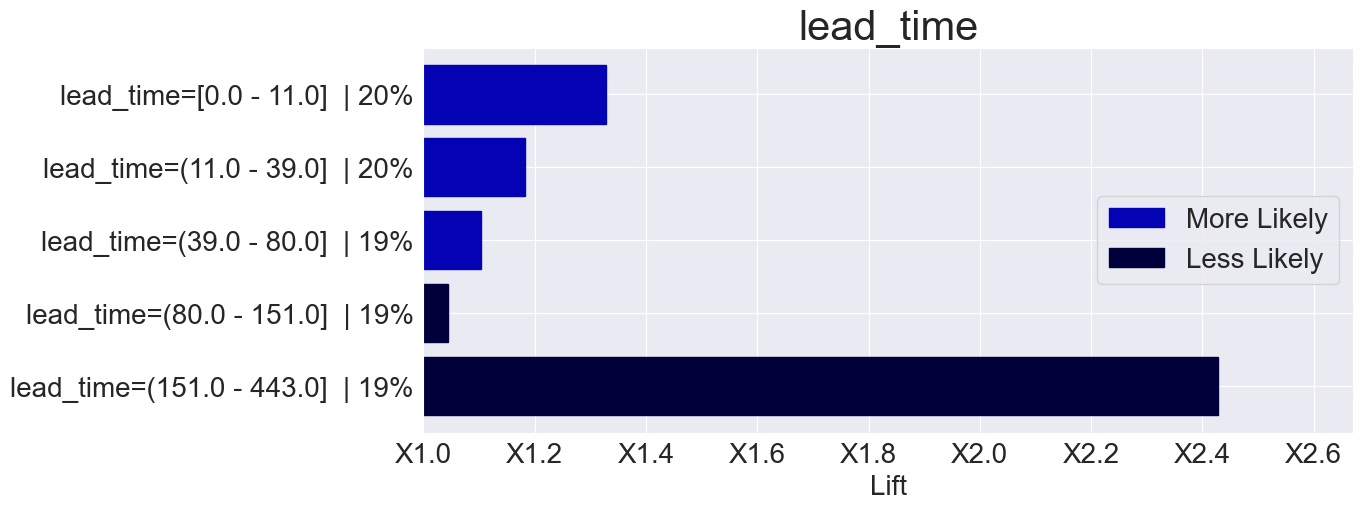

repeated_guest


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
2,repeated_guest=1 ==> booking_status=Not_Canceled,0.025637,0.672364,0.025196,0.9828,1.4617
51,repeated_guest=0 ==> booking_status=Not_Canceled,0.974363,0.672364,0.647167,0.6642,0.9879


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


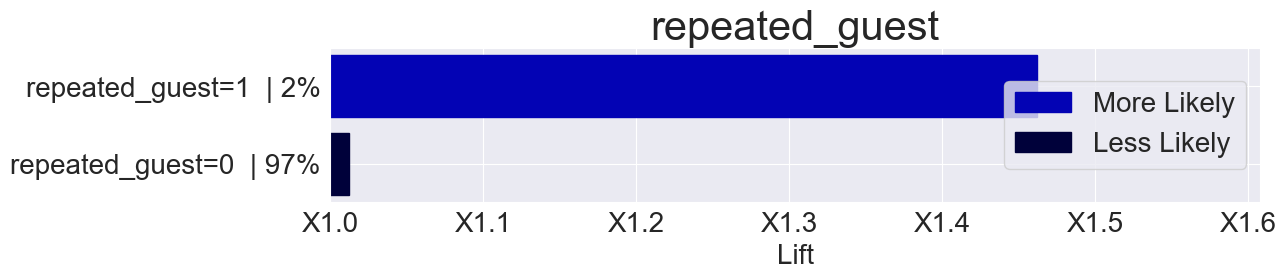

no_of_special_requests


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
1,no_of_special_requests=3 ==> booking_status=Not_Canceled,0.018608,0.672364,0.018608,1.0000,1.4873
8,no_of_special_requests=2 ==> booking_status=Not_Canceled,0.120303,0.672364,0.102743,0.8540,1.2702
13,no_of_special_requests=1 ==> booking_status=Not_Canceled,0.313522,0.672364,0.239008,0.7623,1.1338
86,no_of_special_requests=0 ==> booking_status=Not_Canceled,0.545196,0.672364,0.309635,0.5679,0.8447


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


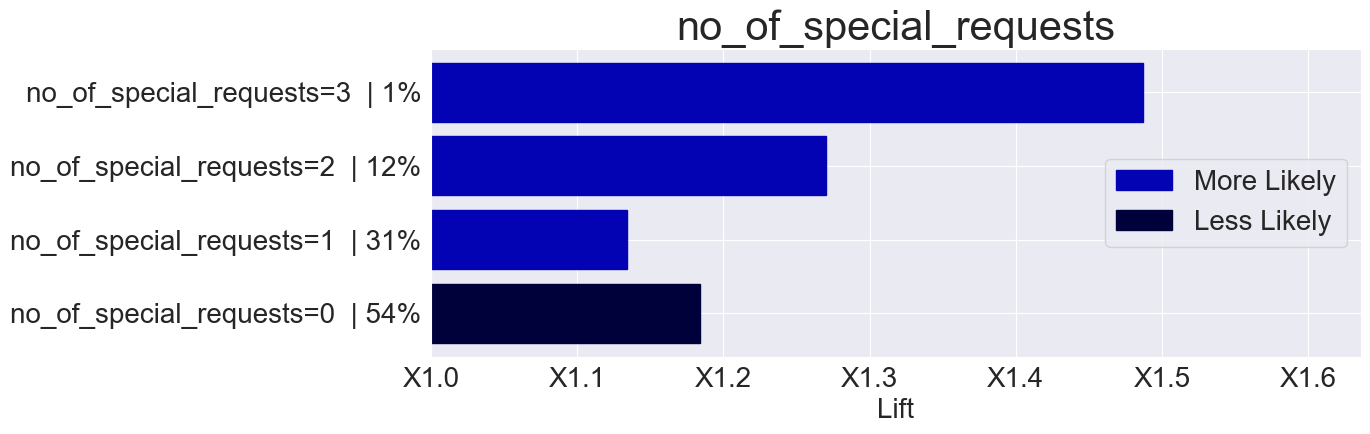

market_segment_type


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
0,market_segment_type=Complementary ==> booking_status=Not_Canceled,0.010779,0.672364,0.010779,1.0000,1.4873
6,market_segment_type=Corporate ==> booking_status=Not_Canceled,0.055603,0.672364,0.049538,0.8909,1.3251
30,market_segment_type=Offline ==> booking_status=Not_Canceled,0.290227,0.672364,0.203308,0.7005,1.0419
70,market_segment_type=Online ==> booking_status=Not_Canceled,0.639945,0.672364,0.406313,0.6349,0.9443


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


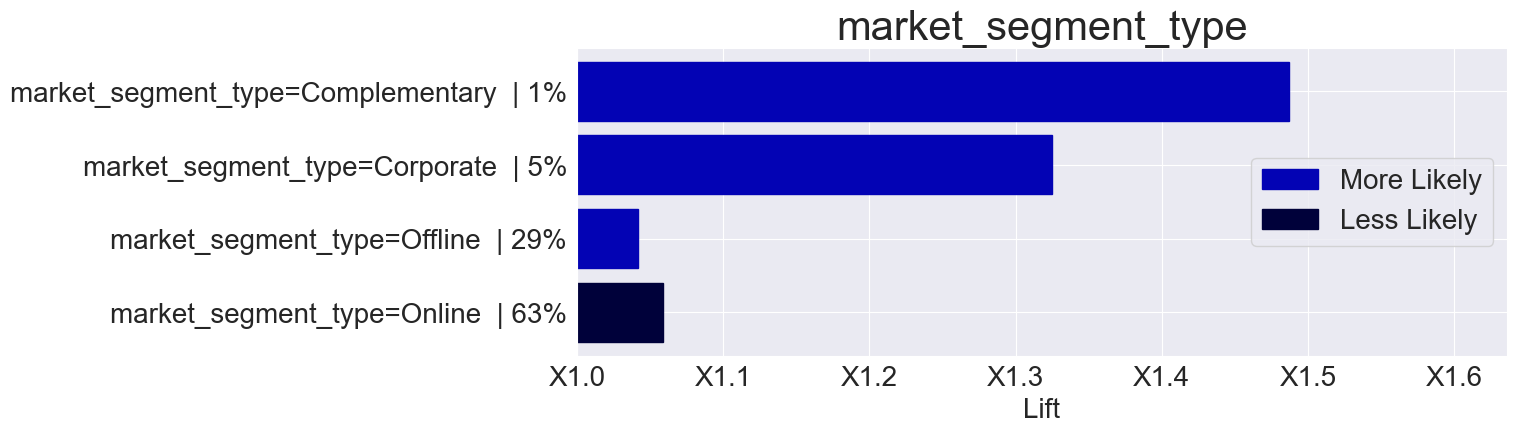

required_car_parking_space


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
4,required_car_parking_space=1 ==> booking_status=Not_Canceled,0.030986,0.672364,0.027843,0.8986,1.3364
49,required_car_parking_space=0 ==> booking_status=Not_Canceled,0.969014,0.672364,0.644521,0.6651,0.9892


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


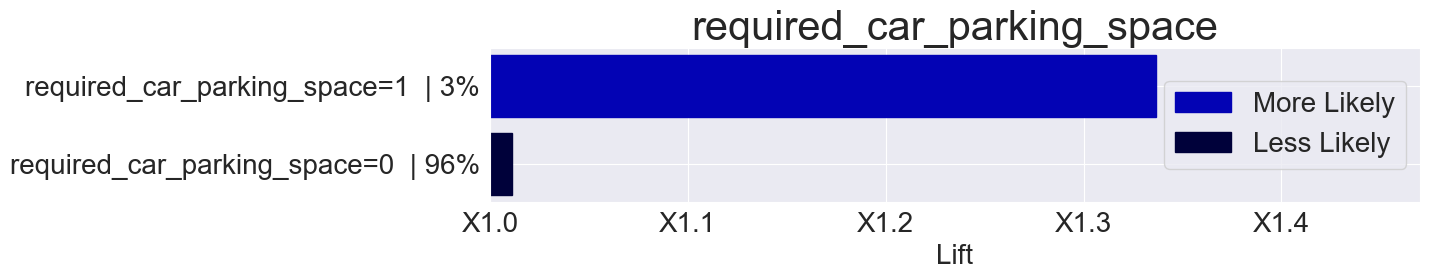

arrival_month


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
3,arrival_month=1 ==> booking_status=Not_Canceled,0.027953,0.672364,0.027292,0.9763,1.4521
7,arrival_month=12 ==> booking_status=Not_Canceled,0.083280,0.672364,0.072198,0.8669,1.2894
15,arrival_month=2 ==> booking_status=Not_Canceled,0.046975,0.672364,0.035121,0.7477,1.1120
26,arrival_month=11 ==> booking_status=Not_Canceled,0.082150,0.672364,0.058029,0.7064,1.0506
28,arrival_month=3 ==> booking_status=Not_Canceled,0.065003,0.672364,0.045706,0.7031,1.0458
47,arrival_month=9 ==> booking_status=Not_Canceled,0.127112,0.672364,0.084714,0.6664,0.9912
63,arrival_month=10 ==> booking_status=Not_Canceled,0.146575,0.672364,0.094748,0.6464,0.9614
68,arrival_month=4 ==> booking_status=Not_Canceled,0.075424,0.672364,0.047994,0.6363,0.9464
69,arrival_month=5 ==> booking_status=Not_Canceled,0.071620,0.672364,0.045486,0.6351,0.9446
79,arrival_month=8 ==> booking_status=Not_Canceled,0.105114,0.672364,0.064094,0.6098,0.9069


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


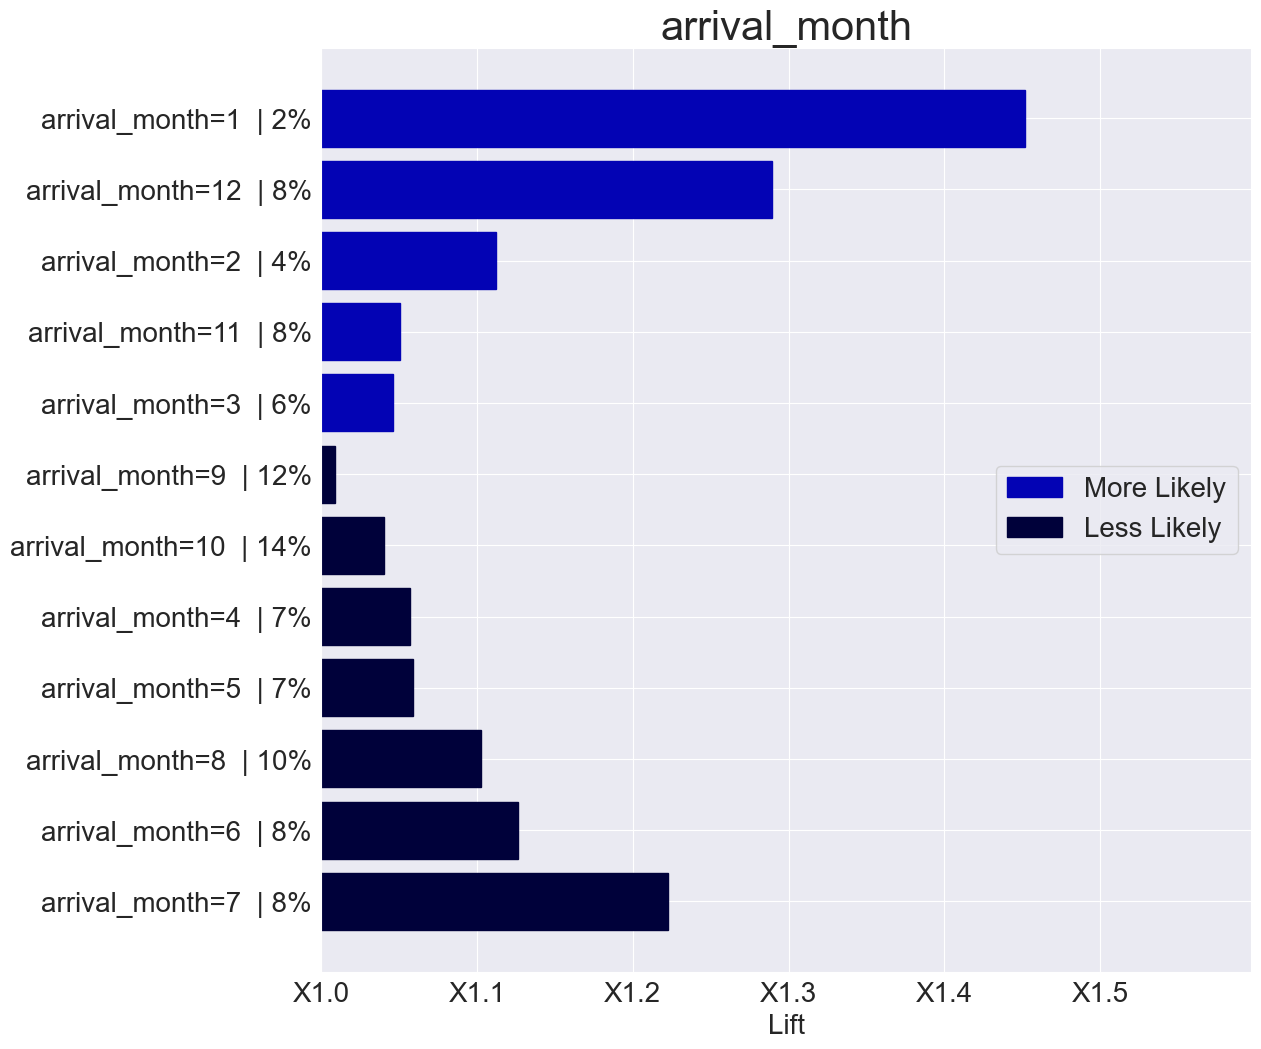

arrival_year


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
9,arrival_year=2017 ==> booking_status=Not_Canceled,0.179573,0.672364,0.153081,0.8525,1.2679
72,arrival_year=2018 ==> booking_status=Not_Canceled,0.820427,0.672364,0.519283,0.6329,0.9414


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


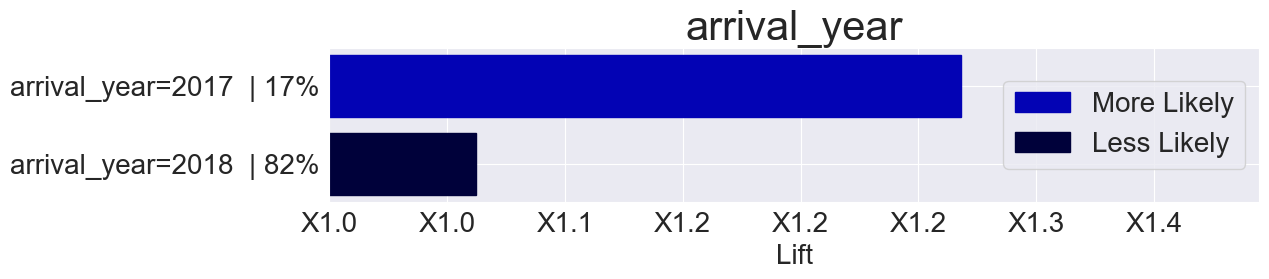

avg_price_per_room


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
10,avg_price_per_room=[0.0 - 76.0] ==> booking_status=Not_Canceled,0.200992,0.672364,0.160469,0.7984,1.1874
20,avg_price_per_room=(76.0 - 91.0] ==> booking_status=Not_Canceled,0.201296,0.672364,0.146492,0.7277,1.0824
58,avg_price_per_room=(91.0 - 108.0] ==> booking_status=Not_Canceled,0.203391,0.672364,0.132874,0.6533,0.9716
75,avg_price_per_room=(129.0 - 540.0] ==> booking_status=Not_Canceled,0.195975,0.672364,0.122316,0.6241,0.9283
87,avg_price_per_room=(108.0 - 129.0] ==> booking_status=Not_Canceled,0.198346,0.672364,0.110214,0.5557,0.8264


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


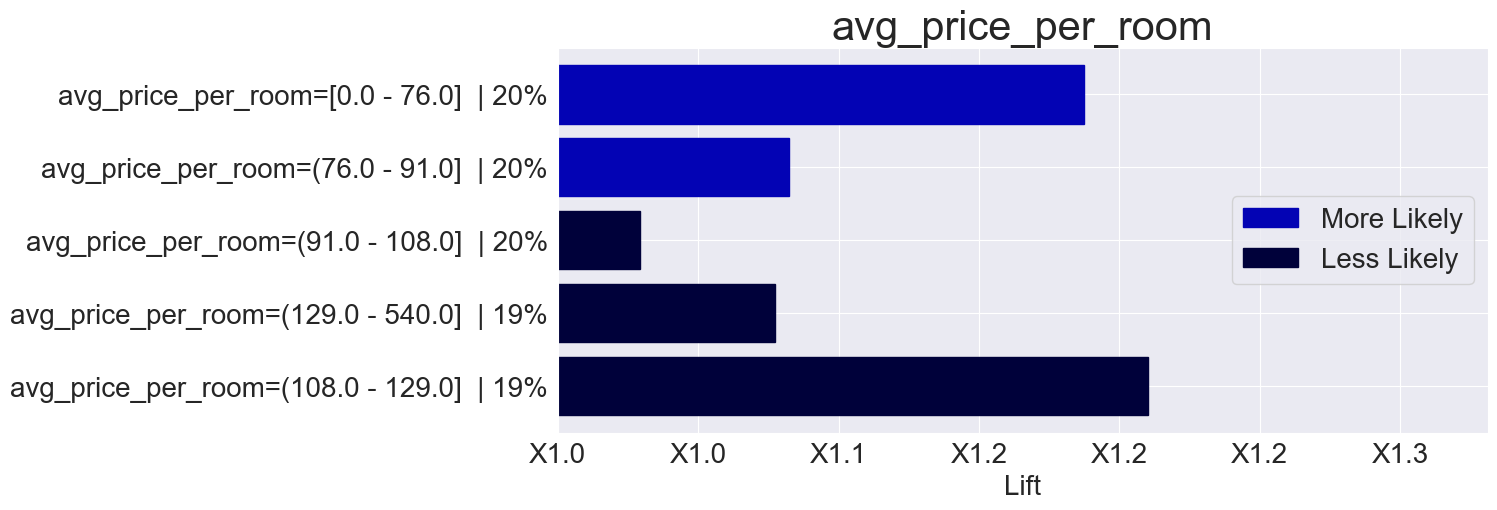

type_of_meal_plan


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
36,type_of_meal_plan=Meal Plan 1 ==> booking_status=Not_Canceled,0.767333,0.672364,0.528077,0.6882,1.0236
45,type_of_meal_plan=Not Selected ==> booking_status=Not_Canceled,0.141420,0.672364,0.094583,0.6688,0.9947
89,type_of_meal_plan=Meal Plan 2 ==> booking_status=Not_Canceled,0.091110,0.672364,0.049593,0.5443,0.8096


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


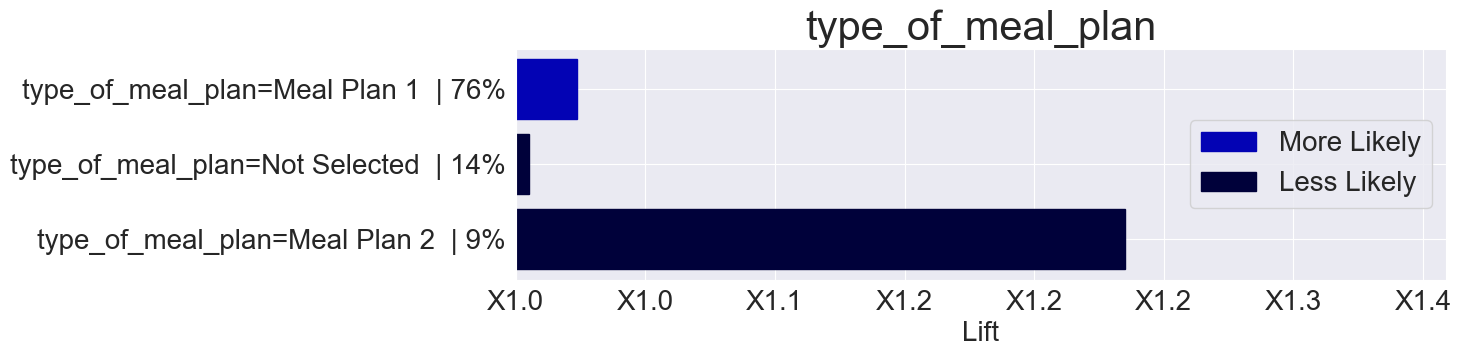

no_of_adults


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
14,no_of_adults=1 ==> booking_status=Not_Canceled,0.212130,0.672364,0.160965,0.7588,1.1286
61,no_of_adults=2 ==> booking_status=Not_Canceled,0.719724,0.672364,0.468339,0.6507,0.9678
74,no_of_adults=3 ==> booking_status=Not_Canceled,0.063873,0.672364,0.040083,0.6275,0.9333


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


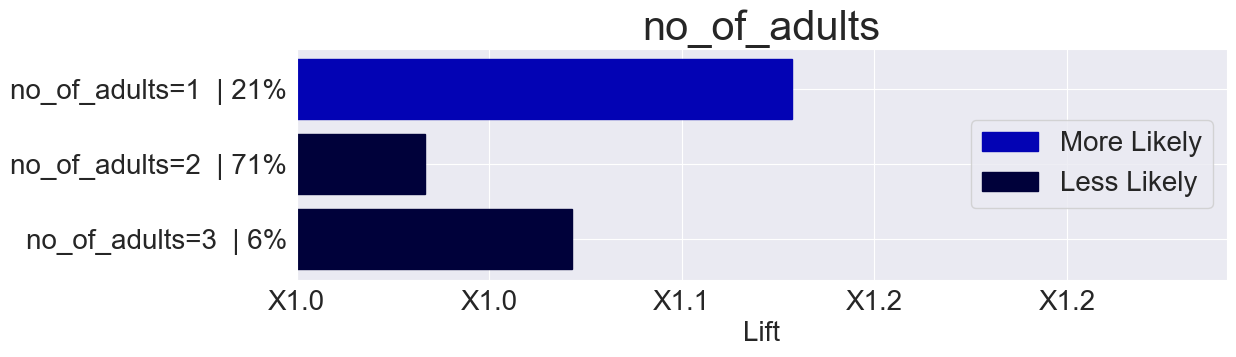

In [7]:

ar.present_rules_per_consequent(rules_2,consequent={'booking_status':'Canceled', 'booking_status':'Not_Canceled'}, drop_dups=True, selection_function=top_10_variant_variables,
                                plot=True)

### Interpretation for rules with 1 antecedent

We noticed that the booking status is influenced by the following attributes:
- Lead time : the longer the lead time, the more likely the booking is canceled
- Arrival month : the booking is more likely to be canceled in the months of July, August and June
- Average price per room : we can notice that the booking is more likely to be canceled when the average price per room is between 108 and 540
- Market segment type : the booking is more likely not to be canceled when the market segment type is Complementary and Aviation
- Number of special requests : the booking is more likely not to be canceled when the number of special requests is greater than 0

Regarding the confidence of each rule:
- For lead time column we have 3 rules with confidence > 0.7 that cover around 60% of the possible values
- For repeatead guest column we have a rule with confidence = 0.98, but with low coverage, with around 2% of the possible values
- For number of special requests column we have 3 rules with confidence > 0.7 that cover around 46% of the possible values
- For market_segment_type column we have 3 rules with confidence > 0.7 that cover around 35% of the possible values
- For required_car_parking_space column we have 1 rule with confidence = 0.89 that covers only around 3% of the possible values
- For arrival_month column we have 5 rules with confidence > 0.7 that cover around 28% of the possible values
- We consider that arrival year does not supply enough information to be considered as an important attribute
- For average price per room column we have 2 rules with confidence > 0.7 that cover around 40% of the possible values
- For type of meal plan column we have rules with small confidence, so more analysis has to be done to determine if this column is important or not
- For number of adults column we 1 rules with confidence > 0.7 that covers around 21% of the possible values

### For rules with 2 antecedents

D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\numpy\core\fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


lead_time , market_segment_type


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
53,"lead_time=(11.0 - 39.0], market_segment_type=Offline ==> booking_status=Not_Canceled",0.046837,0.672364,0.045100,0.9629,1.4321
67,"lead_time=[0.0 - 11.0], market_segment_type=Offline ==> booking_status=Not_Canceled",0.028091,0.672364,0.026216,0.9333,1.3880
68,"lead_time=[0.0 - 11.0], market_segment_type=Corporate ==> booking_status=Not_Canceled",0.031757,0.672364,0.029552,0.9306,1.3840
80,"lead_time=(11.0 - 39.0], market_segment_type=Corporate ==> booking_status=Not_Canceled",0.015190,0.672364,0.013894,0.9147,1.3604
85,"lead_time=(39.0 - 80.0], market_segment_type=Offline ==> booking_status=Not_Canceled",0.057119,0.672364,0.051964,0.9097,1.3531
149,"lead_time=[0.0 - 11.0], market_segment_type=Online ==> booking_status=Not_Canceled",0.128298,0.672364,0.111923,0.8724,1.2975
412,"lead_time=(80.0 - 151.0], market_segment_type=Offline ==> booking_status=Not_Canceled",0.062302,0.672364,0.045899,0.7367,1.0957
449,"lead_time=(11.0 - 39.0], market_segment_type=Online ==> booking_status=Not_Canceled",0.143901,0.672364,0.104700,0.7276,1.0821
744,"lead_time=(39.0 - 80.0], market_segment_type=Online ==> booking_status=Not_Canceled",0.135603,0.672364,0.090779,0.6694,0.9957
1232,"lead_time=(80.0 - 151.0], market_segment_type=Online ==> booking_status=Not_Canceled",0.131661,0.672364,0.078704,0.5978,0.8891


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


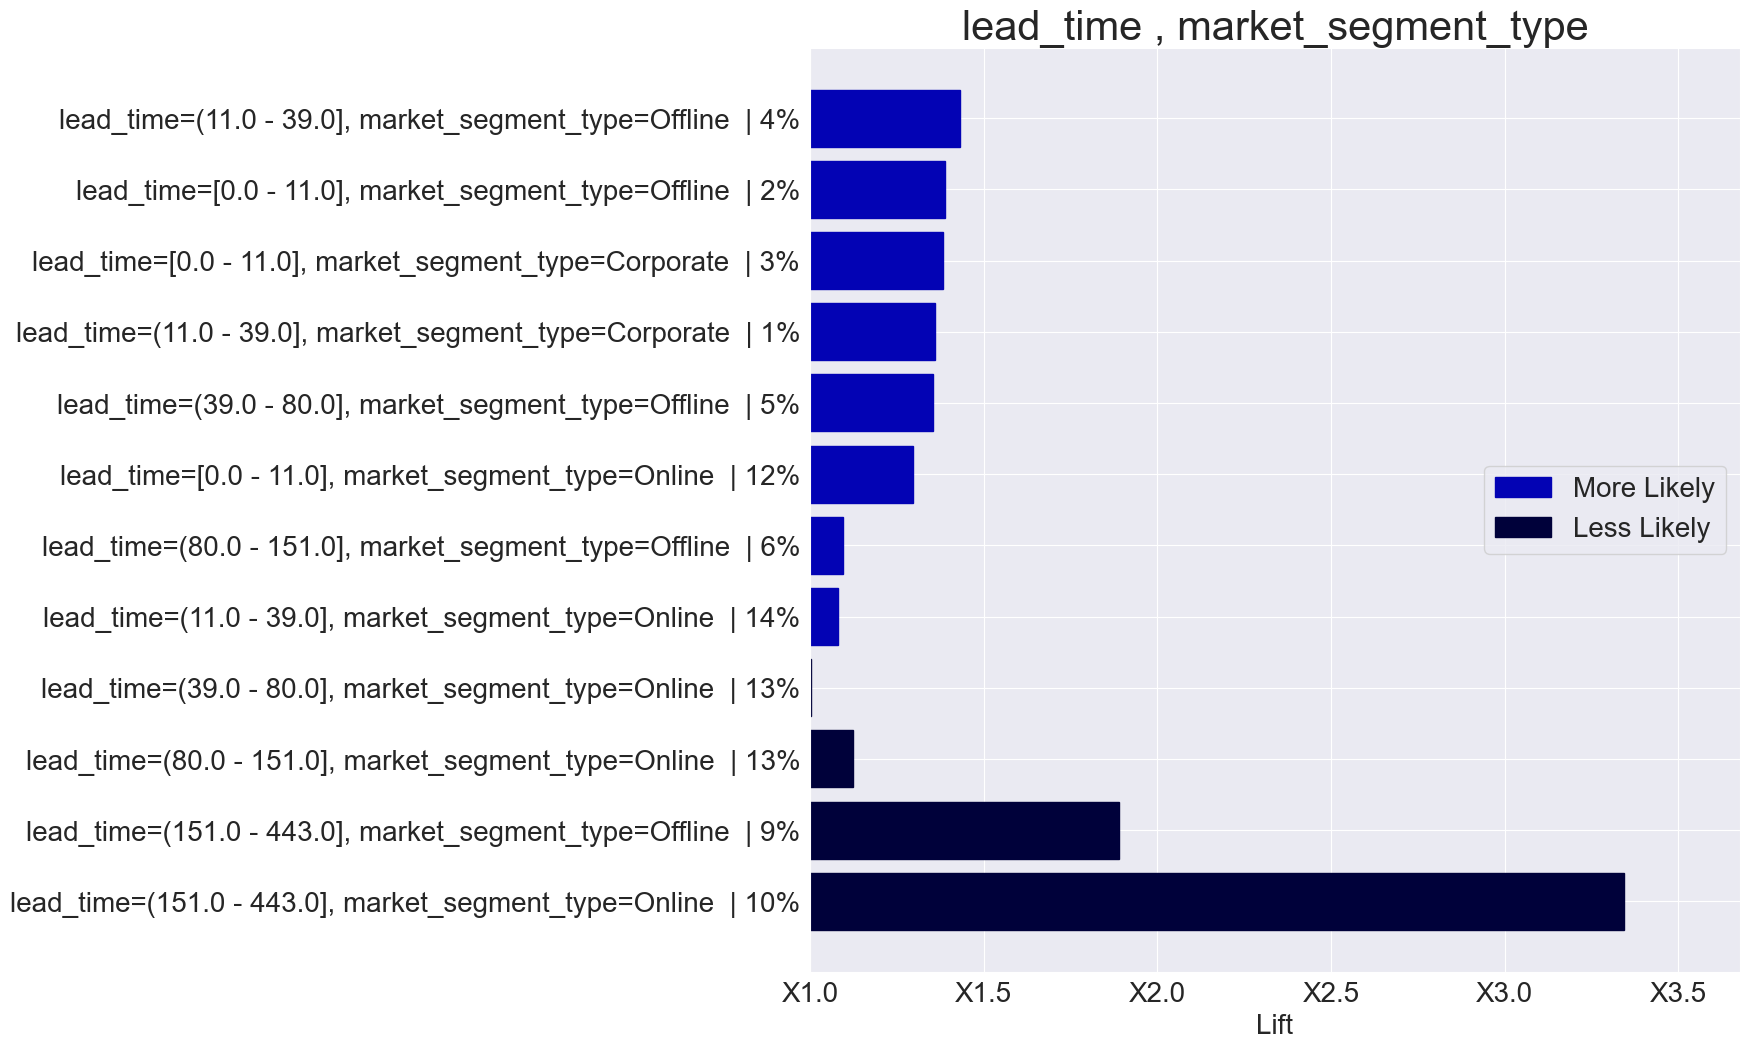

lead_time , no_of_special_requests


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
22,"lead_time=[0.0 - 11.0], no_of_special_requests=2 ==> booking_status=Not_Canceled",0.024700,0.672364,0.024452,0.9900,1.4724
38,"lead_time=(39.0 - 80.0], no_of_special_requests=2 ==> booking_status=Not_Canceled",0.025610,0.672364,0.025003,0.9763,1.4521
47,"lead_time=(11.0 - 39.0], no_of_special_requests=2 ==> booking_status=Not_Canceled",0.029001,0.672364,0.028229,0.9734,1.4477
72,"lead_time=[0.0 - 11.0], no_of_special_requests=1 ==> booking_status=Not_Canceled",0.066051,0.672364,0.061337,0.9286,1.3811
196,"lead_time=(11.0 - 39.0], no_of_special_requests=1 ==> booking_status=Not_Canceled",0.069662,0.672364,0.059159,0.8492,1.2630
205,"lead_time=[0.0 - 11.0], no_of_special_requests=0 ==> booking_status=Not_Canceled",0.104976,0.672364,0.088601,0.8440,1.2553
244,"lead_time=(80.0 - 151.0], no_of_special_requests=2 ==> booking_status=Not_Canceled",0.024259,0.672364,0.019904,0.8205,1.2203
247,"lead_time=(39.0 - 80.0], no_of_special_requests=1 ==> booking_status=Not_Canceled",0.064810,0.672364,0.053039,0.8184,1.2172
306,"lead_time=(80.0 - 151.0], no_of_special_requests=1 ==> booking_status=Not_Canceled",0.061392,0.672364,0.047912,0.7804,1.1607
553,"lead_time=(11.0 - 39.0], no_of_special_requests=0 ==> booking_status=Not_Canceled",0.104176,0.672364,0.073081,0.7015,1.0433


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


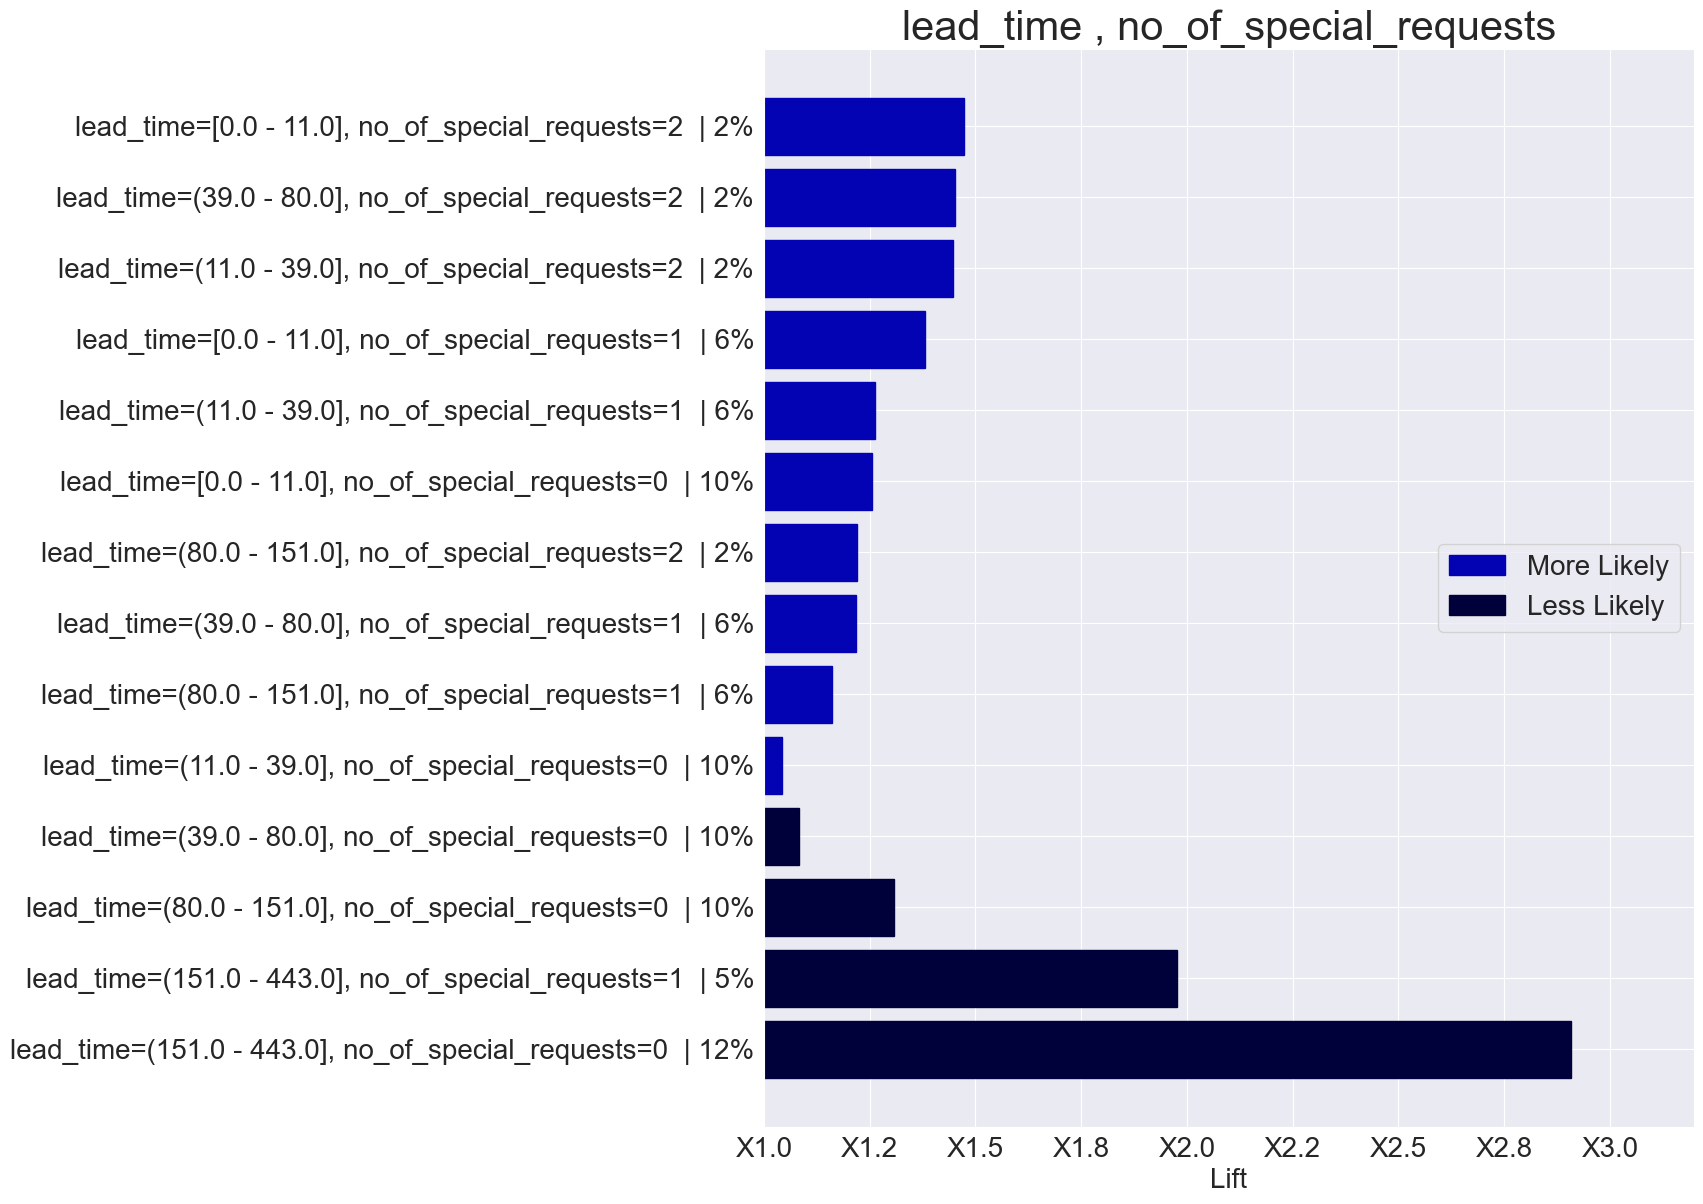

lead_time , repeated_guest


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
10,"lead_time=[0.0 - 11.0], repeated_guest=1 ==> booking_status=Not_Canceled",0.019325,0.672364,0.019325,1.0000,1.4873
138,"lead_time=[0.0 - 11.0], repeated_guest=0 ==> booking_status=Not_Canceled",0.180731,0.672364,0.159394,0.8819,1.3117
288,"lead_time=(11.0 - 39.0], repeated_guest=0 ==> booking_status=Not_Canceled",0.202839,0.672364,0.160496,0.7912,1.1768
396,"lead_time=(39.0 - 80.0], repeated_guest=0 ==> booking_status=Not_Canceled",0.195865,0.672364,0.145224,0.7414,1.1028
964,"lead_time=(80.0 - 151.0], repeated_guest=0 ==> booking_status=Not_Canceled",0.198263,0.672364,0.127581,0.6435,0.9571
1431,"lead_time=(151.0 - 443.0], repeated_guest=0 ==> booking_status=Not_Canceled",0.196664,0.672364,0.054473,0.2770,0.4120


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


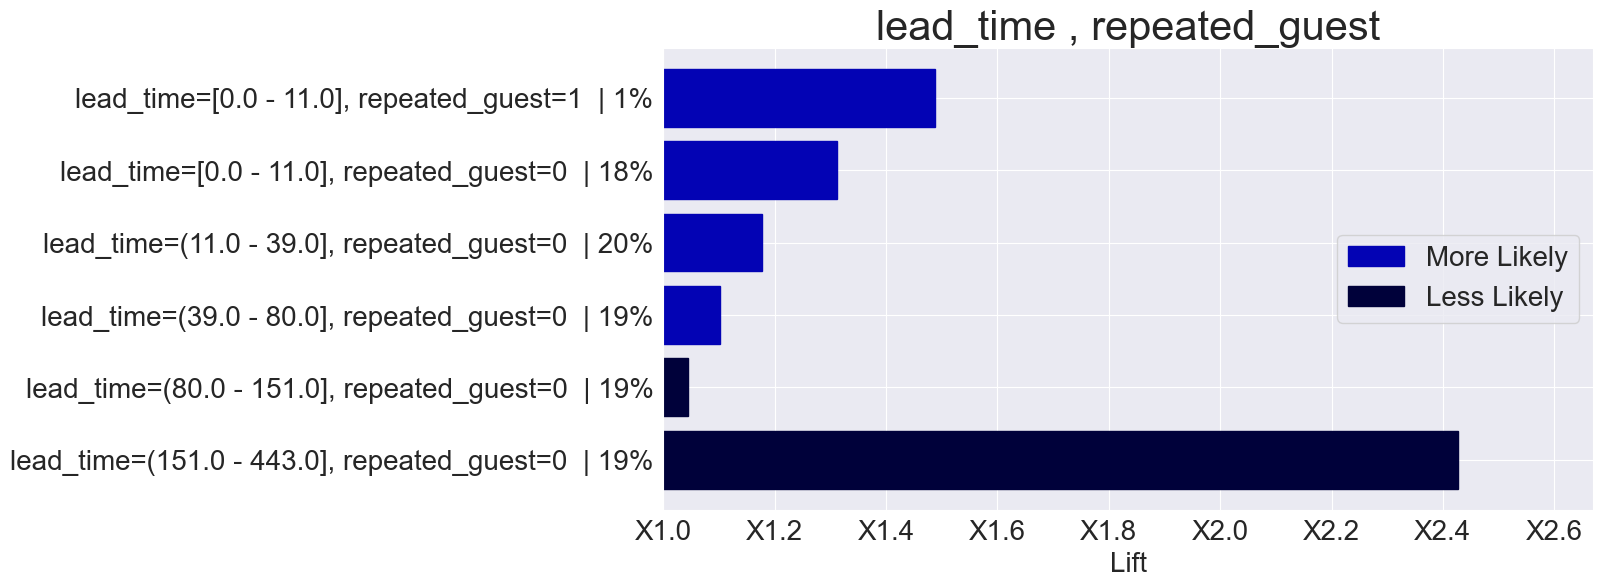

lead_time , required_car_parking_space


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
19,"required_car_parking_space=1, lead_time=[0.0 - 11.0] ==> booking_status=Not_Canceled",0.011992,0.672364,0.011937,0.9954,1.4805
124,"required_car_parking_space=0, lead_time=[0.0 - 11.0] ==> booking_status=Not_Canceled",0.188063,0.672364,0.166782,0.8868,1.3190
293,"required_car_parking_space=0, lead_time=(11.0 - 39.0] ==> booking_status=Not_Canceled",0.201323,0.672364,0.158980,0.7897,1.1745
420,"required_car_parking_space=0, lead_time=(39.0 - 80.0] ==> booking_status=Not_Canceled",0.191868,0.672364,0.141144,0.7356,1.0941
1014,"required_car_parking_space=0, lead_time=(80.0 - 151.0] ==> booking_status=Not_Canceled",0.194183,0.672364,0.123584,0.6364,0.9466
1429,"required_car_parking_space=0, lead_time=(151.0 - 443.0] ==> booking_status=Not_Canceled",0.193577,0.672364,0.054032,0.2791,0.4151


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


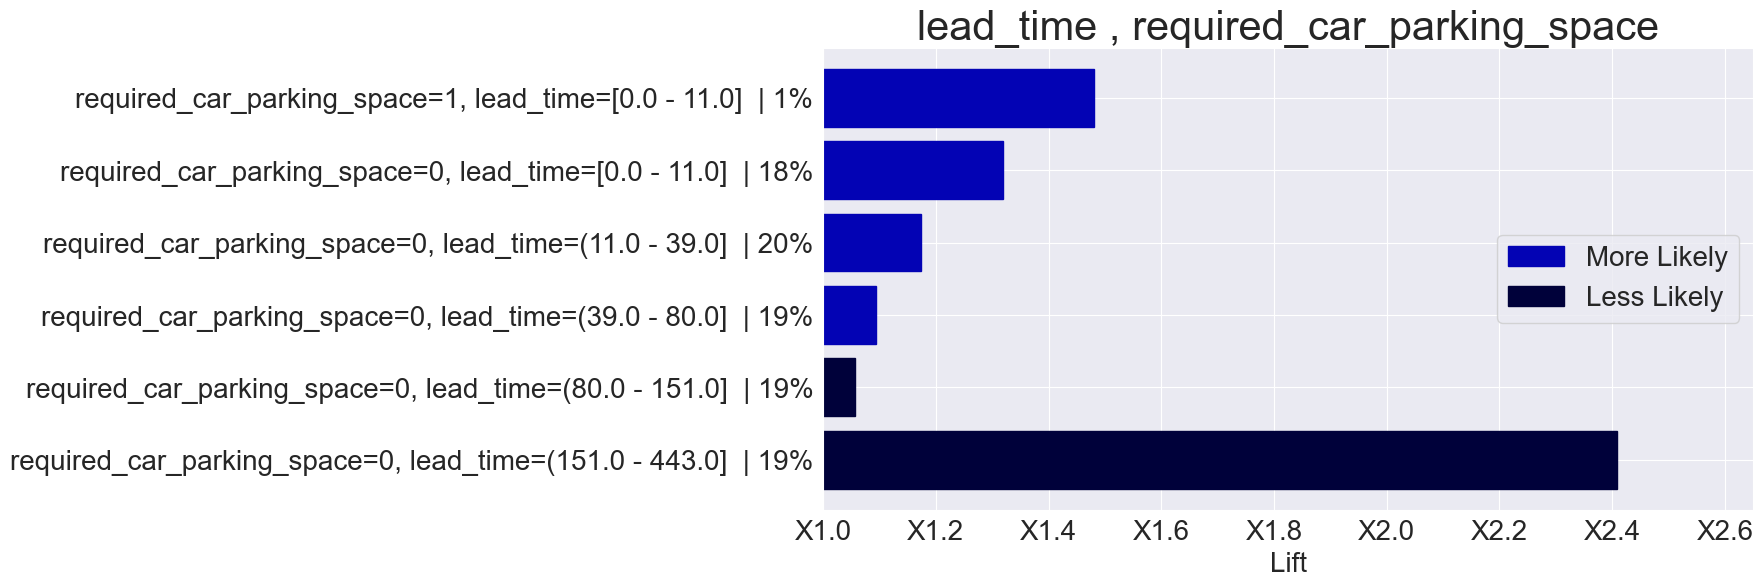

lead_time , no_of_children


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
106,"no_of_children=0, lead_time=[0.0 - 11.0] ==> booking_status=Not_Canceled",0.184948,0.672364,0.165734,0.8961,1.3328
262,"no_of_children=0, lead_time=(11.0 - 39.0] ==> booking_status=Not_Canceled",0.190958,0.672364,0.153715,0.8050,1.1972
378,"no_of_children=0, lead_time=(39.0 - 80.0] ==> booking_status=Not_Canceled",0.180648,0.672364,0.135162,0.7482,1.1128
913,"no_of_children=0, lead_time=(80.0 - 151.0] ==> booking_status=Not_Canceled",0.182605,0.672364,0.118539,0.6492,0.9655
1427,"no_of_children=0, lead_time=(151.0 - 443.0] ==> booking_status=Not_Canceled",0.186465,0.672364,0.052488,0.2815,0.4187


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labs_x)


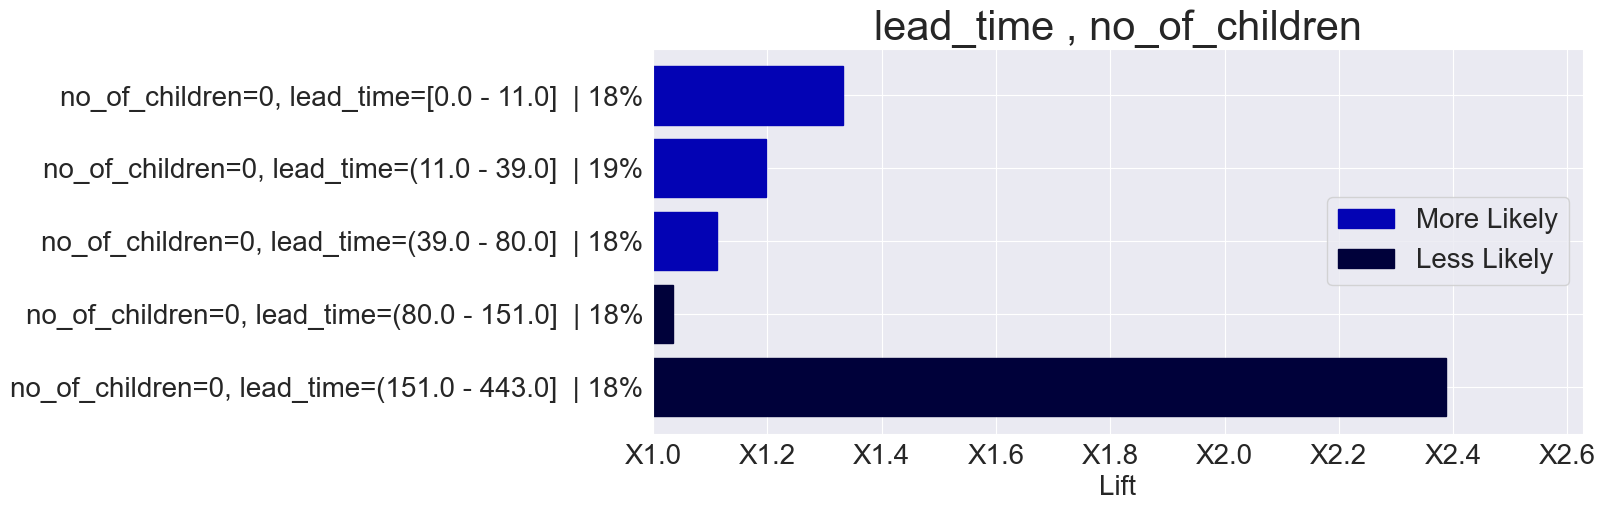

In [8]:
pd.options.display.max_colwidth = 100
ar.present_rules_per_consequent(rules_3,consequent={'booking_status':'Canceled', 'booking_status':'Not_Canceled'}, drop_dups=True, selection_function=top_5_variant_variables,
                                plot=True)

# R code for graphs

```
library(arulesViz)

df <- read.csv("D:\\Facultate\\DM\\Hotel Reservations.csv", header = TRUE, sep = ",")

rules <- apriori(df, parameter = list(support = 0.005, confidence = 0.5, maxlen=3, target="rules"),)

plot(rules) #scatter

plot(rules, method = "graph", limit = 20)
```

# Alternative method (without graphs)

In [ ]:
del hotel[hotel.columns[0]]
hotel = hotel[1:]

In [7]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [ ]:
categorical_columns = [
    "type_of_meal_plan",
    "required_car_parking_space",
    "room_type_reserved",
    "market_segment_type",
    "repeated_guest",
    "booking_status"
]

hotel = hotel.drop(['Booking_ID'], axis=1)  

numerical_columns = hotel.columns.difference(categorical_columns)


In [111]:
#implement association rules for every column
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

def discretize(df, column, bins, labels):
    df[column] = pd.cut(df[column], bins=bins, labels=labels)

#discretize average price
bins = [i * 25 for i in range(24)]
labels =  ["P" + str(i * 25) + "-" + str((i+1) * 25) for i in range(23)]

hotel[16] = hotel[16].astype('float64')
discretize(hotel, 16, bins=bins, labels=labels)
hotel[16] = hotel[16].astype('object')

bins = [i * 25 for i in range(18)]
labels =  ["L" + str(i * 25) + "-" + str((i+1) * 25) for i in range(17)]
hotel[8] = hotel[8].astype('int64')
discretize(hotel, 8, bins=bins, labels=labels)
hotel[8] = hotel[8].astype('object')

col_abvr = ['AD_', 'CH_', 'WEN_', "WKN_", "", "PARK_", "", "", "", "MON_", "DATE_", "", "REP_", "PC_", "PNC_", "", "SPEC_", ""]
print(len(col_abvr))
print(hotel.shape[1])
for i in range(len(col_abvr)):
    hotel.iloc[:,i] = col_abvr[i] + hotel.iloc[:,i].astype(str)
    



18
18


## Association rules for all attributes (support/confidence experiments)

In [112]:
from apyori import apriori, load_transactions

print(hotel.shape[0])
print(hotel.shape[1])

# Intializing the list
transacts = []
rows = hotel.shape[0]
columns = hotel.shape[1]
for i in range(rows):
    transacts.append([str(hotel.values[i,j]) for j in range(0, columns)])

print("TRANSCATIONS : ", len(transacts) * len(transacts[0]))
    


36275
18
TRANSCATIONS :  652950


In [113]:
rule = apriori(transactions = transacts, min_support = 0.003, min_confidence = 0.1, min_length = 2, max_length = 3)
output = list(rule) # returns a non-tabular output

def inspect(output):
    lhs         = [", ".join(tuple(result[2][0][0])) for result in output]
    rhs         = [tuple(result[2][0][1])[0] for result in output]
    support    = [result[1] for result in output]
    confidence = [result[2][0][2] for result in output]
    lift       = [result[2][0][3] for result in output]
    return list(zip(lhs, rhs, support, confidence, lift))

output_DataFrame = pd.DataFrame(inspect(output), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
0,,2017,0.179573,0.179573,1.000000
1,,2018,0.820427,0.820427,1.000000
2,,AD_1,0.212130,0.212130,1.000000
3,,AD_2,0.719724,0.719724,1.000000
4,,CH_0,0.925624,0.925624,1.000000
...,...,...,...,...,...
33305,"WEN_2, SPEC_2",WKN_3,0.007223,0.209265,0.968375
33306,"WEN_2, SPEC_2",WKN_5,0.003694,0.107029,2.405494
33307,nan,WKN_1,0.021337,0.443553,3.166054
33308,nan,WEN_0,0.006726,0.139828,0.882901


In [99]:
output_DataFrame = pd.DataFrame(inspect(output), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame

# output_DataFrame.nlargest(n = 50, columns = 'Confidence')

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
0,,2017,0.179573,0.179573,1.000000
1,,2018,0.820427,0.820427,1.000000
2,,AD_1,0.212130,0.212130,1.000000
3,,AD_2,0.719724,0.719724,1.000000
4,,CH_0,0.925624,0.925624,1.000000
...,...,...,...,...,...
33305,"WEN_2, SPEC_2",WKN_3,0.007223,0.209265,0.968375
33306,"WEN_2, SPEC_2",WKN_5,0.003694,0.107029,2.405494
33307,nan,WKN_1,0.021337,0.443553,3.166054
33308,nan,WEN_0,0.006726,0.139828,0.882901


In [104]:
#select the rules with canceled and not_canceled as right hand side
output_DataFrame_2 = output_DataFrame[output_DataFrame['Right_Hand_Side'].str.contains("Canceled") | output_DataFrame['Right_Hand_Side'].str.contains("Not_Canceled")]
output_DataFrame_2.nlargest(n = 50, columns = 'Confidence')

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
735,Complementary,Not_Canceled,0.010779,1.000000,1.487290
2555,PNC_2,Not_Canceled,0.003088,1.000000,1.487290
2567,SPEC_3,Not_Canceled,0.018608,1.000000,1.487290
2557,REP_1,Not_Canceled,0.025196,0.982796,1.461702
2554,PNC_1,Not_Canceled,0.006175,0.982456,1.461197
2156,MON_1,Not_Canceled,0.027292,0.976331,1.452088
2552,PC_1,Not_Canceled,0.005155,0.944444,1.404663
2577,nan,Not_Canceled,0.044907,0.933524,1.388421
686,L375-400,Canceled,0.003529,0.914286,2.790552
2546,P25-50,Not_Canceled,0.007002,0.903915,1.344383
